In [19]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

# Function to set the seed for reproducibility
def set_seed(seed_value):
    np.random.seed(seed_value)

seed_value = 42  # You can modify this value
set_seed(seed_value)  # Set the seed for reproducibility

# Ensure inline plotting in Jupyter
%matplotlib inline


In [20]:
# Function to load all images from the current folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):  # Only process .jpg files
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append((filename, img))
                print(f"Loaded image: {filename}")  # Debug: Print the image loaded
            else:
                print(f"Failed to load image: {filename}")  # Debug: Failed loading
    return images

folder = './Ass2'  # Path to your images folder
images = load_images_from_folder(folder)

if not images:
    print("No images found in the folder.")


Loaded image: T22.jpg
Loaded image: T32.jpg
Loaded image: T42.jpg
Loaded image: T52.jpg
Loaded image: T62.jpg


In [21]:
# Otsu’s Method Multilevel Thresholding
def otsu_multilevel_thresholding(image, levels):
    thresholds = []
    current_image = image.copy()

    for _ in range(levels - 1):
        thresh_value, _ = cv2.threshold(current_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholds.append(thresh_value)
        current_image = np.where(current_image >= thresh_value, 0, current_image)

    segmented_image = np.zeros_like(image)
    for i, thresh in enumerate(sorted(thresholds)):
        segmented_image[np.where(image >= thresh)] = (i + 1) * (255 // levels)

    return segmented_image, thresholds

# Kapur’s Method Thresholding (maximizes entropy)
def kapur_threshold(image, levels):
    # Compute the histogram and normalize it
    hist, bins = np.histogram(image.ravel(), bins=256, range=[0, 256])
    hist = hist.astype(np.float32) / hist.sum()

    def entropy(thresh):
        prob1 = hist[:thresh].sum()
        prob2 = hist[thresh:].sum()
        prob1 = prob1 if prob1 > 0 else 1
        prob2 = prob2 if prob2 > 0 else 1
        return -(np.log(prob1) * prob1 + np.log(prob2) * prob2)

    thresholds = []
    current_image = image.copy()
    
    for _ in range(levels - 1):
        # Calculate entropy for all possible threshold values in the remaining region
        entropies = [entropy(thresh) for thresh in range(1, 255)]
        best_thresh = np.argmax(entropies)
        thresholds.append(best_thresh)
        
        # Split the image at the current threshold and only look for thresholds in the remaining regions
        hist[:best_thresh] = 0  # Set the current region to zero to avoid reselecting it
        
    # Sort the thresholds for correct segmentation
    thresholds = sorted(thresholds)
    thresholds = [0] + thresholds + [255]  # Add 0 and 255 as the boundary thresholds

    # Segment the image based on the thresholds
    segmented_image = np.zeros_like(image)
    for i in range(len(thresholds) - 1):
        mask = (image >= thresholds[i]) & (image < thresholds[i + 1])
        segmented_image[mask] = (i + 1) * (255 // levels)

    # Normalize the segmented image for better visualization
    normalized_segmented_image = cv2.normalize(segmented_image, None, 0, 255, cv2.NORM_MINMAX)

    return normalized_segmented_image, thresholds

In [22]:
# Simulated Annealing for Thresholding Optimization
def simulated_annealing(image, objective_function, levels, initial_temperature=1000, cooling_rate=0.95):
    def perturb(thresholds):
        idx = np.random.randint(0, len(thresholds))
        thresholds[idx] += np.random.randint(-10, 10)
        thresholds = np.clip(thresholds, 0, 255)
        return thresholds

    current_thresholds = np.sort(np.random.randint(0, 255, size=(levels - 1)))
    current_cost = objective_function(image, current_thresholds)
    temperature = initial_temperature

    while temperature > 1:
        new_thresholds = perturb(current_thresholds.copy())
        new_cost = objective_function(image, new_thresholds)

        if new_cost < current_cost or np.random.random() < np.exp((current_cost - new_cost) / temperature):
            current_thresholds = new_thresholds
            current_cost = new_cost

        temperature *= cooling_rate

    return current_thresholds

# Variable Neighbourhood Search for Thresholding Optimization
def vns(image, objective_function, levels):
    current_thresholds = np.sort(np.random.randint(0, 255, size=(levels - 1)))
    best_cost = objective_function(image, current_thresholds)

    def local_search(thresholds):
        for i in range(len(thresholds)):
            for change in [-5, 5]:
                new_thresholds = thresholds.copy()
                new_thresholds[i] += change
                new_thresholds = np.clip(new_thresholds, 0, 255)
                new_cost = objective_function(image, new_thresholds)
                if new_cost < best_cost:
                    return new_thresholds, new_cost
        return thresholds, best_cost

    while True:
        new_thresholds, new_cost = local_search(current_thresholds)
        if new_cost < best_cost:
            current_thresholds = new_thresholds
            best_cost = new_cost
        else:
            break

    return current_thresholds

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def display_images(images, titles, cols=2, figsize=(5, 3)):  
    rows = (len(images) + cols - 1) // cols  # Calculate the number of rows dynamically
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    if rows == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Debug: Print unique values for each image
            unique_values = np.unique(images[i])
            print(f"Image: {titles[i]}, Unique values: {unique_values}")

            # Normalize the segmented images for better visualization
            norm_img = cv2.normalize(images[i], None, 0, 255, cv2.NORM_MINMAX)
            
            # Display original image in grayscale
            if 'Original' in titles[i]:
                ax.imshow(norm_img, cmap='gray')  # Ensure original is grayscale
            # Apply 'jet' colormap if there are 3 or more unique values (sections)
            elif len(unique_values) >= 3:
                ax.imshow(norm_img, cmap='jet', vmin=0, vmax=255)  # Use 'jet' colormap with normalization
            else:
                ax.imshow(norm_img, cmap='gray')  # Use grayscale if fewer than 3 sections
            
            ax.set_title(titles[i], fontsize=8)  # Reduced title font size for smaller images
        else:
            ax.axis('off')  # Hide unused subplots
        ax.axis('off')  # Turn off the axis ticks

    plt.tight_layout()
    plt.show()


# Logging function to print and store results
def log_results(df, image_name, level, method, optimization, thresholds, obj_value, ssim_value, psnr_value, unique_values):
    new_row = pd.DataFrame({
        'Image': [image_name], 
        'Level': [level], 
        'Method': [method], 
        'Optimization': [optimization], 
        'Thresholds': [thresholds], 
        'Unique Values': [unique_values],
        'Objective Value': [obj_value], 
        'SSIM': [ssim_value], 
        'PSNR': [psnr_value]
    })
    df = pd.concat([df, new_row], ignore_index=True)
    return df


# Objective function (Otsu)
def otsu_objective(image, thresholds):
    thresholds = [0] + sorted(thresholds) + [255]
    total_var = 0
    for i in range(len(thresholds) - 1):
        mask = (image >= thresholds[i]) & (image < thresholds[i+1])
        region = image[mask]
        if len(region) > 0:
            total_var += np.var(region) * len(region)
    return total_var

# Objective function (Kapur)
def kapur_objective(image, thresholds):
    thresholds = [0] + sorted(thresholds) + [255]
    total_entropy = 0
    for i in range(len(thresholds) - 1):
        mask = (image >= thresholds[i]) & (image < thresholds[i+1])
        hist, _ = np.histogram(image[mask], bins=256, range=[0, 256])
        hist = hist.astype(np.float32) / hist.sum()
        entropy = -np.sum(hist * np.log(hist + 1e-10))
        total_entropy += entropy
    return -total_entropy


# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Image', 'Level', 'Method', 'Optimization', 'Thresholds', 'Objective Value', 'SSIM', 'PSNR'])


Processing image: T22.jpg
Processing k=2
Unique values for T22_SA_Otsu_k2: [  0 127]
Unique values for T22_SA_Kapur_k2: [  0 255]
Unique values for T22_VNS_Otsu_k2: [  0 127]
Unique values for T22_VNS_Kapur_k2: [  0 255]
Processing k=3
Unique values for T22_SA_Otsu_k3: [  0  85 170]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\3643536964.py:108: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T22_SA_Kapur_k3: [  0 128 255]
Unique values for T22_VNS_Otsu_k3: [  0  85 170]
Unique values for T22_VNS_Kapur_k3: [  0 128 255]
Processing k=4
Unique values for T22_SA_Otsu_k4: [  0  63 126 189]
Unique values for T22_SA_Kapur_k4: [  0  85 170 255]
Unique values for T22_VNS_Otsu_k4: [  0  63 126 189]
Unique values for T22_VNS_Kapur_k4: [  0  85 170 255]
Processing k=5
Unique values for T22_SA_Otsu_k5: [  0  51 102 153 204]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\3643536964.py:108: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T22_SA_Kapur_k5: [  0  64 128 191 255]
Unique values for T22_VNS_Otsu_k5: [  0  51 102 153 204]
Unique values for T22_VNS_Kapur_k5: [  0  64 128 191 255]
Image: T22_Original, Unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 1

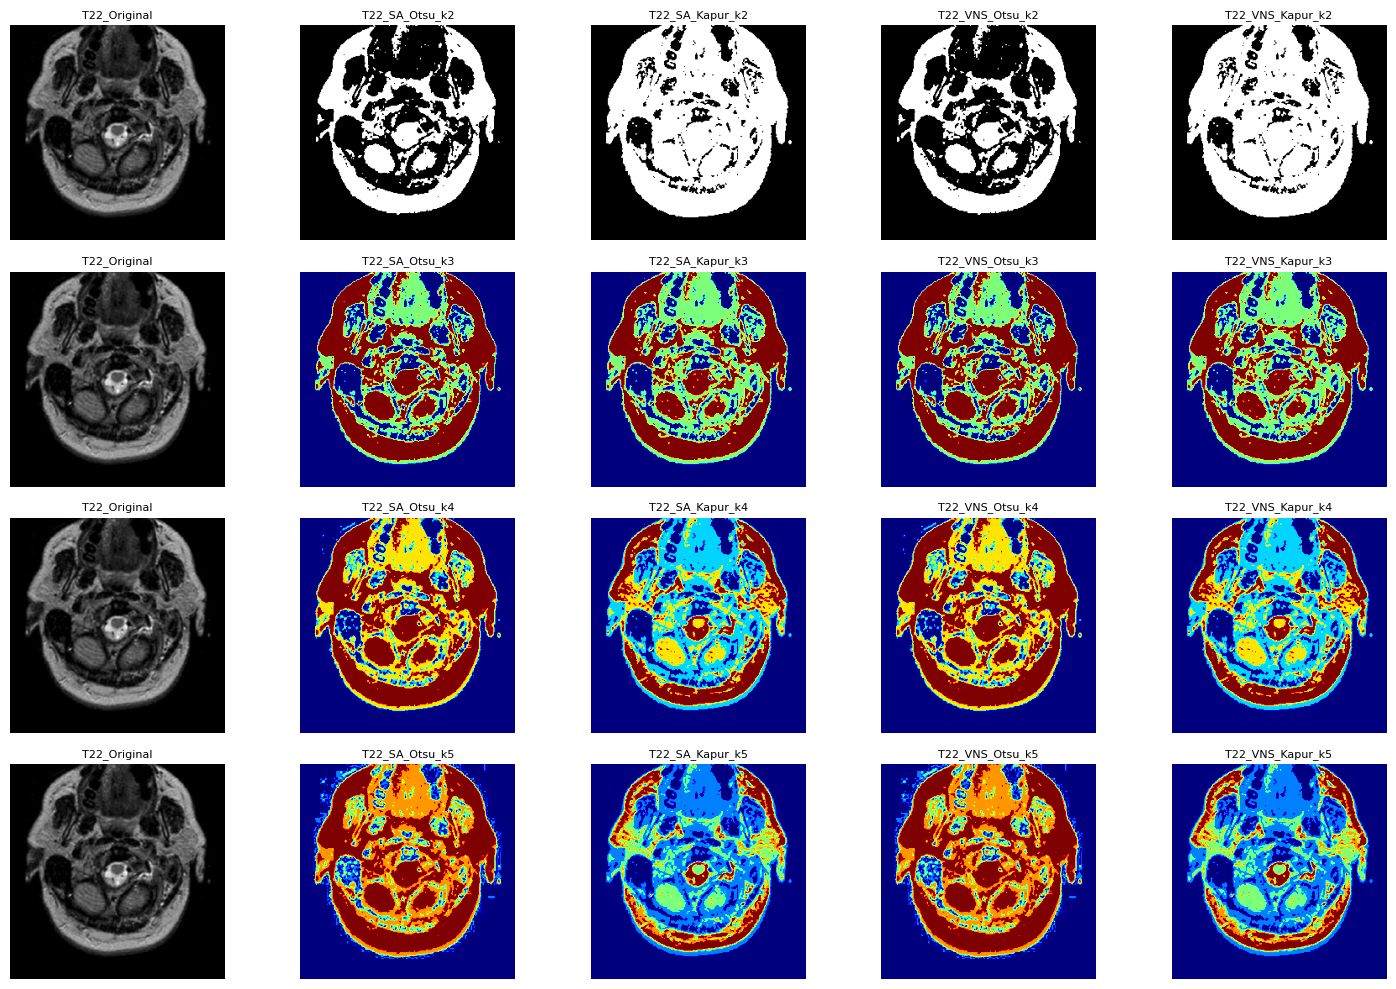

Processing image: T32.jpg
Processing k=2
Unique values for T32_SA_Otsu_k2: [  0 127]
Unique values for T32_SA_Kapur_k2: [  0 128 255]
Unique values for T32_VNS_Otsu_k2: [  0 127]
Unique values for T32_VNS_Kapur_k2: [  0 128 255]
Processing k=3
Unique values for T32_SA_Otsu_k3: [  0  85 170]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\3643536964.py:108: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T32_SA_Kapur_k3: [  0  85 170 255]
Unique values for T32_VNS_Otsu_k3: [  0  85 170]
Unique values for T32_VNS_Kapur_k3: [  0  85 170 255]
Processing k=4
Unique values for T32_SA_Otsu_k4: [  0  63 126 189]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\3643536964.py:108: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T32_SA_Kapur_k4: [  0  64 127 191 255]
Unique values for T32_VNS_Otsu_k4: [  0  63 126 189]
Unique values for T32_VNS_Kapur_k4: [  0  64 127 191 255]
Processing k=5
Unique values for T32_SA_Otsu_k5: [  0  51 102 153 204]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\3643536964.py:108: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T32_SA_Kapur_k5: [  0  51 102 153 204 255]
Unique values for T32_VNS_Otsu_k5: [  0  51 102 153 204]
Unique values for T32_VNS_Kapur_k5: [  0  51 102 153 204 255]
Image: T32_Original, Unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 1

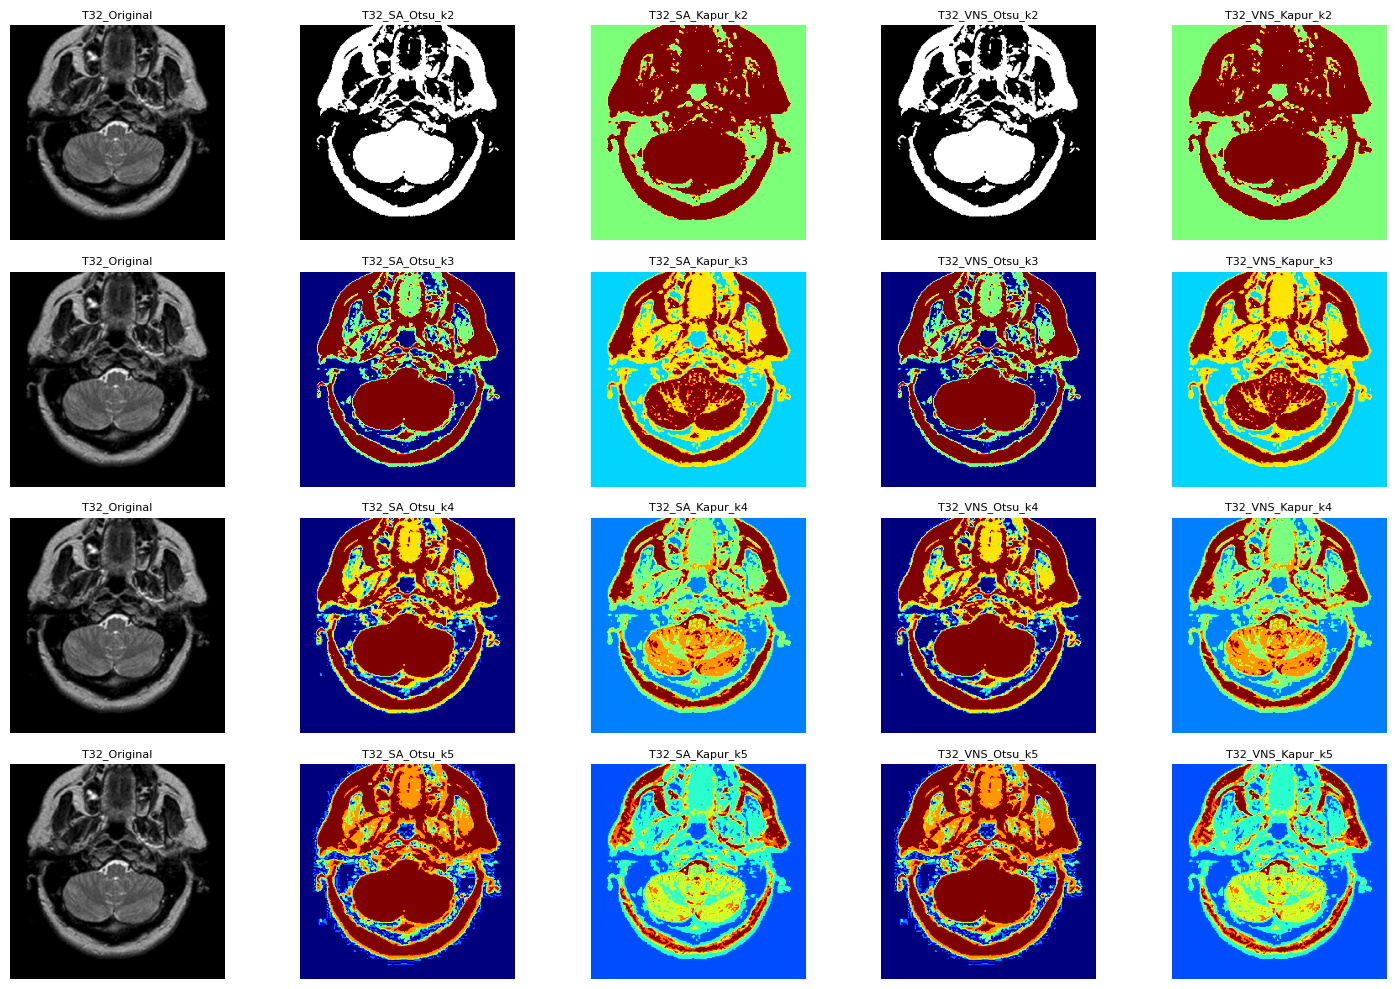

Processing image: T42.jpg
Processing k=2
Unique values for T42_SA_Otsu_k2: [  0 127]
Unique values for T42_SA_Kapur_k2: [  0 128 255]
Unique values for T42_VNS_Otsu_k2: [  0 127]
Unique values for T42_VNS_Kapur_k2: [  0 128 255]
Processing k=3
Unique values for T42_SA_Otsu_k3: [  0  85 170]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\3643536964.py:108: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T42_SA_Kapur_k3: [  0  85 170 255]
Unique values for T42_VNS_Otsu_k3: [  0  85 170]
Unique values for T42_VNS_Kapur_k3: [  0  85 170 255]
Processing k=4
Unique values for T42_SA_Otsu_k4: [  0  63 126 189]
Unique values for T42_SA_Kapur_k4: [  0  64 127 191 255]


KeyboardInterrupt: 

In [25]:
# import matplotlib.pyplot as plt

# # Function to plot the histogram of the image
# def plot_histogram(image, title):
#     plt.figure(figsize=(6, 4))
#     plt.hist(image.ravel(), bins=256, range=[0,256], color='blue', alpha=0.7)
#     plt.title(f'Gray Level Histogram of {title}')
#     plt.xlabel('Pixel Intensity')
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()

# # Create an empty DataFrame to store results
# results_df = pd.DataFrame(columns=['Image', 'Level', 'Method', 'Optimization', 'Thresholds', 'Objective Value', 'SSIM', 'PSNR'])

# # Main execution block for image processing with results logging
# for filename, image in images:
#     name_without_extension = os.path.splitext(filename)[0]
#     print(f"Processing image: {filename}")
    
#     processed_images = []  # List to store processed images across multiple k
#     image_titles = []      # List to store titles of images
    
#     # Loop through different k levels (e.g., k=2, k=3, etc.)
#     for k in [2, 3, 4, 5]:
#         print(f"Processing k={k}")
        
#         # Simulated Annealing + Otsu
#         sa_thresholds = simulated_annealing(image, otsu_objective, k)
#         segmented_sa_otsu, _ = otsu_multilevel_thresholding(image, len(sa_thresholds) + 1)
#         ssim_sa_otsu = ssim(image, segmented_sa_otsu)
#         psnr_sa_otsu = psnr(image, segmented_sa_otsu)
#         otsu_obj_value = otsu_objective(image, sa_thresholds)  # Calculate objective value
#         print(f"Unique values for {name_without_extension}_SA_Otsu_k{k}: {np.unique(segmented_sa_otsu)}")
#         results_df = log_results(results_df, name_without_extension, k, "Otsu", "SA", sa_thresholds, otsu_obj_value, ssim_sa_otsu, psnr_sa_otsu, np.unique(segmented_sa_otsu).tolist())
#         processed_images.append(segmented_sa_otsu)
#         image_titles.append(f'{name_without_extension}_SA_Otsu_k{k}')
        
#         # Simulated Annealing + Kapur
#         sa_thresholds = simulated_annealing(image, kapur_objective, k)
#         segmented_sa_kapur, _ = kapur_threshold(image, len(sa_thresholds) + 1)
#         ssim_sa_kapur = ssim(image, segmented_sa_kapur)
#         psnr_sa_kapur = psnr(image, segmented_sa_kapur)
#         kapur_obj_value = kapur_objective(image, sa_thresholds)  # Calculate objective value
#         print(f"Unique values for {name_without_extension}_SA_Kapur_k{k}: {np.unique(segmented_sa_kapur)}")
#         results_df = log_results(results_df, name_without_extension, k, "Kapur", "SA", sa_thresholds, kapur_obj_value, ssim_sa_kapur, psnr_sa_kapur, np.unique(segmented_sa_kapur).tolist())
#         processed_images.append(segmented_sa_kapur)
#         image_titles.append(f'{name_without_extension}_SA_Kapur_k{k}')

#         # Variable Neighbourhood Search + Otsu
#         vns_thresholds = vns(image, otsu_objective, k)
#         segmented_vns_otsu, _ = otsu_multilevel_thresholding(image, len(vns_thresholds) + 1)
#         ssim_vns_otsu = ssim(image, segmented_vns_otsu)
#         psnr_vns_otsu = psnr(image, segmented_vns_otsu)
#         otsu_obj_value_vns = otsu_objective(image, vns_thresholds)  # Calculate objective value
#         print(f"Unique values for {name_without_extension}_VNS_Otsu_k{k}: {np.unique(segmented_vns_otsu)}")
#         results_df = log_results(results_df, name_without_extension, k, "Otsu", "VNS", vns_thresholds, otsu_obj_value_vns, ssim_vns_otsu, psnr_vns_otsu, np.unique(segmented_vns_otsu).tolist())
#         processed_images.append(segmented_vns_otsu)
#         image_titles.append(f'{name_without_extension}_VNS_Otsu_k{k}')
        
#         # Variable Neighbourhood Search + Kapur
#         vns_thresholds = vns(image, kapur_objective, k)
#         segmented_vns_kapur, _ = kapur_threshold(image, len(vns_thresholds) + 1)
#         ssim_vns_kapur = ssim(image, segmented_vns_kapur)
#         psnr_vns_kapur = psnr(image, segmented_vns_kapur)
#         kapur_obj_value_vns = kapur_objective(image, vns_thresholds)  # Calculate objective value
#         print(f"Unique values for {name_without_extension}_VNS_Kapur_k{k}: {np.unique(segmented_vns_kapur)}")
#         results_df = log_results(results_df, name_without_extension, k, "Kapur", "VNS", vns_thresholds, kapur_obj_value_vns, ssim_vns_kapur, psnr_vns_kapur, np.unique(segmented_vns_kapur).tolist())
#         processed_images.append(segmented_vns_kapur)
#         image_titles.append(f'{name_without_extension}_VNS_Kapur_k{k}')

#     # Call the display_images function to show processed images side by side in a grid format
#     display_images(processed_images, image_titles, cols=5, figsize=(15, 10))  # This displays in a grid of 4 images per row

# # ! USED TO LOG VALUES TO CSV FILE
# # After the loop, output the results DataFrame
# display(results_df)

# # Save the logged results to a CSV file
# results_df.to_csv('segmentation_results.csv', index=False)

# print("Results have been logged and saved to 'segmentation_results.csv'.")


import matplotlib.pyplot as plt

# Function to plot the histogram of the image
def plot_histogram(image, title):
    plt.figure(figsize=(6, 4))
    plt.hist(image.ravel(), bins=256, range=[0, 256], color='blue', alpha=0.7)
    plt.title(f'Gray Level Histogram of {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Image', 'Level', 'Method', 'Optimization', 'Thresholds', 'Objective Value', 'SSIM', 'PSNR'])

# Main execution block for image processing with results logging
for filename, image in images:
    name_without_extension = os.path.splitext(filename)[0]
    print(f"Processing image: {filename}")
    
    processed_images = []  # List to store processed images across multiple k
    image_titles = []      # List to store titles of images

    # Loop through different k levels (e.g., k=2, k=3, etc.)
    for k in [2, 3, 4, 5]:
        print(f"Processing k={k}")
        
        # Append the original image before each row of processed images
        original_image = image.copy()  # Copy of the original image
        processed_images.append(original_image)
        image_titles.append(f'{name_without_extension}_Original')

        # Simulated Annealing + Otsu
        sa_thresholds = simulated_annealing(image, otsu_objective, k)
        segmented_sa_otsu, _ = otsu_multilevel_thresholding(image, len(sa_thresholds) + 1)
        ssim_sa_otsu = ssim(image, segmented_sa_otsu)
        psnr_sa_otsu = psnr(image, segmented_sa_otsu)
        otsu_obj_value = otsu_objective(image, sa_thresholds)  # Calculate objective value
        print(f"Unique values for {name_without_extension}_SA_Otsu_k{k}: {np.unique(segmented_sa_otsu)}")
        results_df = log_results(results_df, name_without_extension, k, "Otsu", "SA", sa_thresholds, otsu_obj_value, ssim_sa_otsu, psnr_sa_otsu, np.unique(segmented_sa_otsu).tolist())
        processed_images.append(segmented_sa_otsu)
        image_titles.append(f'{name_without_extension}_SA_Otsu_k{k}')
        
        # Simulated Annealing + Kapur
        sa_thresholds = simulated_annealing(image, kapur_objective, k)
        segmented_sa_kapur, _ = kapur_threshold(image, len(sa_thresholds) + 1)
        ssim_sa_kapur = ssim(image, segmented_sa_kapur)
        psnr_sa_kapur = psnr(image, segmented_sa_kapur)
        kapur_obj_value = kapur_objective(image, sa_thresholds)  # Calculate objective value
        print(f"Unique values for {name_without_extension}_SA_Kapur_k{k}: {np.unique(segmented_sa_kapur)}")
        results_df = log_results(results_df, name_without_extension, k, "Kapur", "SA", sa_thresholds, kapur_obj_value, ssim_sa_kapur, psnr_sa_kapur, np.unique(segmented_sa_kapur).tolist())
        processed_images.append(segmented_sa_kapur)
        image_titles.append(f'{name_without_extension}_SA_Kapur_k{k}')

        # Variable Neighbourhood Search + Otsu
        vns_thresholds = vns(image, otsu_objective, k)
        segmented_vns_otsu, _ = otsu_multilevel_thresholding(image, len(vns_thresholds) + 1)
        ssim_vns_otsu = ssim(image, segmented_vns_otsu)
        psnr_vns_otsu = psnr(image, segmented_vns_otsu)
        otsu_obj_value_vns = otsu_objective(image, vns_thresholds)  # Calculate objective value
        print(f"Unique values for {name_without_extension}_VNS_Otsu_k{k}: {np.unique(segmented_vns_otsu)}")
        results_df = log_results(results_df, name_without_extension, k, "Otsu", "VNS", vns_thresholds, otsu_obj_value_vns, ssim_vns_otsu, psnr_vns_otsu, np.unique(segmented_vns_otsu).tolist())
        processed_images.append(segmented_vns_otsu)
        image_titles.append(f'{name_without_extension}_VNS_Otsu_k{k}')
        
        # Variable Neighbourhood Search + Kapur
        vns_thresholds = vns(image, kapur_objective, k)
        segmented_vns_kapur, _ = kapur_threshold(image, len(vns_thresholds) + 1)
        ssim_vns_kapur = ssim(image, segmented_vns_kapur)
        psnr_vns_kapur = psnr(image, segmented_vns_kapur)
        kapur_obj_value_vns = kapur_objective(image, vns_thresholds)  # Calculate objective value
        print(f"Unique values for {name_without_extension}_VNS_Kapur_k{k}: {np.unique(segmented_vns_kapur)}")
        results_df = log_results(results_df, name_without_extension, k, "Kapur", "VNS", vns_thresholds, kapur_obj_value_vns, ssim_vns_kapur, psnr_vns_kapur, np.unique(segmented_vns_kapur).tolist())
        processed_images.append(segmented_vns_kapur)
        image_titles.append(f'{name_without_extension}_VNS_Kapur_k{k}')

    # Display images with the original image at the beginning of every row
    display_images(processed_images, image_titles, cols=5, figsize=(15, 10))  # Display 5 images per row

# After the loop, output the results DataFrame
display(results_df)

# Save the logged results to a CSV file
results_df.to_csv('segmentation_results.csv', index=False)

print("Results have been logged and saved to 'segmentation_results.csv'.")                                                                                                                                        